In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import cv2
import os

from tqdm import tqdm
from IPython.display import clear_output
from scipy.stats import zscore
from IPython.display import SVG

from keras.utils.vis_utils import plot_model, model_to_dot
from keras.models import Sequential, Model
from keras.callbacks import Callback
from keras.optimizers import Adam, rmsprop
from keras.applications import Xception
from keras.layers import Conv2D, SeparableConv2D, Dense, Flatten, concatenate, multiply, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input

Using TensorFlow backend.


In [2]:
train_dir = 'DATASET/chest_xray/chest_xray/train/'
val_dir = 'DATASET/chest_xray/chest_xray/test/'

HEIGHT, WIDTH = 256,256

**Loading Training Data**

In [3]:
data_size = len(os.listdir(train_dir+'PNEUMONIA'))+len(os.listdir(train_dir+'NORMAL'))
X = np.zeros((data_size,HEIGHT,WIDTH,3))
y = np.zeros((data_size, 2))
i = 0
for subdir in ['NORMAL/', 'PNEUMONIA/']:
    for file in tqdm(os.listdir(train_dir+subdir)):
        try:
            X[i] = cv2.resize(cv2.imread(train_dir+subdir+file), (HEIGHT,WIDTH))/255
        except:
            pass # Error for reading .DS_Store file
        if subdir == 'NORMAL/':
            y[i] = np.array([1,0])
        else:
            y[i] = np.array([0,1])
        i += 1

100%|██████████| 3876/3876 [00:52<00:00, 73.65it/s]


**Loading Validation Data**

In [4]:
data_size = len(os.listdir(val_dir+'PNEUMONIA'))+len(os.listdir(val_dir+'NORMAL'))
X_ = np.zeros((data_size,HEIGHT,WIDTH,3))
y_ = np.zeros((data_size, 2))
i = 0
for subdir in ['NORMAL/', 'PNEUMONIA/']:
    for file in tqdm(os.listdir(val_dir+subdir)):
        try:
            X_[i] = cv2.resize(cv2.imread(val_dir+subdir+file), (HEIGHT,WIDTH))/255
        except:
            pass # Error for reading .DS_Store file
        if subdir == 'NORMAL/':
            y_[i] = np.array([1,0])
        else:
            y_[i] = np.array([0,1])
        i += 1

100%|██████████| 390/390 [00:04<00:00, 79.27it/s]


In [5]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('Log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="acc")
        ax2.plot(self.x, self.val_acc, label="val_acc")
        ax2.legend()
        
        plt.show()
        
        
plot = PlotLearning()

In [6]:
input_layer = Input((HEIGHT, WIDTH, 3))

hidden_layer1 = Conv2D(8, (3,3), activation='relu')(input_layer)
hidden_layer2 = SeparableConv2D(8, (3,3), activation='relu')(input_layer)
hidden_layer1 = Conv2D(8, (3,3), activation='relu')(hidden_layer1)
hidden_layer2 = SeparableConv2D(8, (3,3), activation='relu')(hidden_layer2)

hidden_layer1 = BatchNormalization()(hidden_layer1)
hidden_layer2 = BatchNormalization()(hidden_layer2)

hidden_layer1 = MaxPooling2D((3,3))(hidden_layer1)
hidden_layer2 = MaxPooling2D((3,3))(hidden_layer2)

hidden_layer1 = Conv2D(16, (3,3), activation='relu')(hidden_layer1)
hidden_layer2 = SeparableConv2D(16, (3,3), activation='relu')(hidden_layer2)
hidden_layer1 = Conv2D(16, (3,3), activation='relu')(hidden_layer1)
hidden_layer2 = SeparableConv2D(16, (3,3), activation='relu')(hidden_layer2)

hidden_layer1 = BatchNormalization()(hidden_layer1)
hidden_layer2 = BatchNormalization()(hidden_layer2)

hidden_layer1 = MaxPooling2D((2,2))(hidden_layer1)
hidden_layer2 = MaxPooling2D((2,2))(hidden_layer2)

hidden_layer1 = Conv2D(32, (5,5), activation='relu')(hidden_layer1)
hidden_layer2 = SeparableConv2D(32, (5,5), activation='relu')(hidden_layer2)
hidden_layer1 = Conv2D(32, (5,5), activation='relu')(hidden_layer1)
hidden_layer2 = SeparableConv2D(32, (5,5), activation='relu')(hidden_layer2)

hidden_layer1 = MaxPooling2D((4,4))(hidden_layer1)
hidden_layer2 = MaxPooling2D((4,4))(hidden_layer2)

hidden_layer = concatenate([hidden_layer1, hidden_layer2])

hidden_layer = GlobalAveragePooling2D()(hidden_layer)
hidden_layer = Dense(60, activation='sigmoid')(hidden_layer)
hidden_layer = BatchNormalization()(hidden_layer)

output_layer = Dense(2, activation='softmax')(hidden_layer)

model = Model(input_layer, output_layer)
model.compile(
    optimizer=rmsprop(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 254, 254, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 254, 254, 8)  59          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 252, 252, 8)  584         conv2d_1[0][0]                   
_____________________________________

In [7]:
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

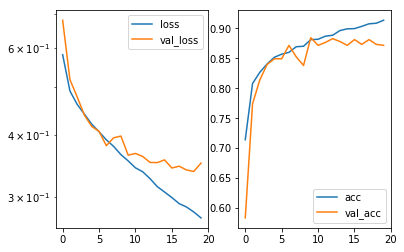

In [8]:
model.fit(X, y, validation_data=(X_,y_), batch_size=64, epochs=20, shuffle=True, callbacks=[plot])


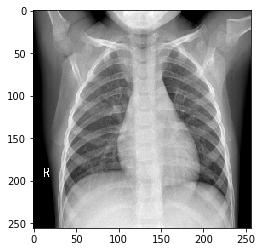

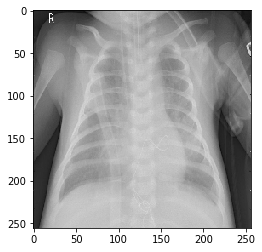

(256, 256, 3)

In [9]:
test_img1 = cv2.resize(cv2.imread(train_dir+'NORMAL/IM-0427-0001.jpeg'), (HEIGHT,WIDTH))
test_img2 = cv2.resize(cv2.imread(train_dir+'PNEUMONIA/person755_bacteria_2659.jpeg'), (HEIGHT, WIDTH))
plt.imshow(test_img1)
plt.show()
plt.imshow(test_img2)
plt.show()
test_img1.shape